In [1]:
### In this notebook I will implement the deep learning model. TO evaluate the ability to cluster the individuall cell cluster

In [1]:
# importing the libraries
import os
import sys
import pandas as pd
import torch
from torch.utils import data
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import  glob
import time
import albumentations 

/home/aa-ssun2-cmp/anaconda3/envs/Harry_Img/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import glob
img_dir = '../../2022_05_18_cells_50_NORMAL/Cross_Validation/iteration_3/train/' 
# I only use the normal images
image_files = glob.glob(img_dir + '*/*.png')
labels = [x.split('/')[-2] for x in image_files]


cellnames = {'cellname': labels}
cellnames = pd.DataFrame(data=cellnames)
cellnames['dir'] = image_files

cellnames.head()

,cellname,dir
0,M5,../../2022_05_18_cells_50_NORMAL/Cross_Validat...
1,M5,../../2022_05_18_cells_50_NORMAL/Cross_Validat...
2,M5,../../2022_05_18_cells_50_NORMAL/Cross_Validat...
3,M5,../../2022_05_18_cells_50_NORMAL/Cross_Validat...
4,M5,../../2022_05_18_cells_50_NORMAL/Cross_Validat...


In [87]:
X_train = glob.glob('../../2022_05_18_cells_50_NORMAL/Cross_Validation/iteration_3/train/*/*')
X_test = glob.glob('../../2022_05_18_cells_50_NORMAL/Cross_Validation/iteration_3/val/*/*')

# remove the difficult classes

X_train = [x for x in X_train if x.split('/')[-2] not in ['PL2','PL3','PL4','U1']]
X_test = [x for x in X_test if x.split('/')[-2] not in ['PL2','PL3','PL4','U1']]

In [8]:
import pandas as pd
import numpy as np# creating initial dataframe
labels = [x.split('/')[-2] for x in X_train]
cell_types = set(cellnames['cellname'])

cell_types = list(cell_types)
cell_types.sort()

cell_types_df = pd.DataFrame(cell_types[:19], columns=['Cell_Types'])# converting type of columns to 'category'
cell_types_df['Cell_Types'] = cell_types_df['Cell_Types'].astype('category')# Assigning numerical values and storing in another column
cell_types_df['Cell_Types_Cat'] = cell_types_df['Cell_Types'].cat.codes


from sklearn.preprocessing import OneHotEncoder# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(cell_types_df[['Cell_Types_Cat']]).toarray())# merge with main df bridge_df on key values
cell_types_df = cell_types_df.join(enc_df)

cell_types_df

,Cell_Types,Cell_Types_Cat,0,1,2,3,4,5,6,7,...,9,10,11,12,13,14,15,16,17,18
0,B1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,B2,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,E4,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ER1,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,ER2,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,ER3,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,ER4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,ER5,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,ER6,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
### Try the pretrained VGG19 model

import torch
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True  # Interesting! This worked for no reason haha
resnext50_pretrained = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)

Using cache found in /home/aa-ssun2-cmp/.cache/torch/hub/pytorch_vision_v0.10.0


In [80]:

class Myresnext50(nn.Module):
    def __init__(self, my_pretrained_model):
        super(Myresnext50, self).__init__()
        self.pretrained = my_pretrained_model
        self.my_new_layers = nn.Sequential(nn.Linear(1000, 100),
                                           nn.ReLU(),
                                           nn.Linear(100, 19))
    
    def forward(self, x):
        x = self.pretrained(x)
        x = self.my_new_layers(x)
        
        pred = torch.sigmoid(x.reshape(x.shape[0], 1,19))
        return pred

my_extended_model = Myresnext50(my_pretrained_model= resnext50_pretrained)


In [81]:
transform_pipeline = albumentations.Compose(
    [
        albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        
    ]
)

In [82]:
class Img_DataLoader(data.Dataset):
    def __init__(self, img_list='', in_dim=3, split='train', transform=False, in_size=96, df = None, encoder = None):
        super(Img_DataLoader, self).__init__()
        self.split = split
        self.in_dim = in_dim
        self.transform = transform
        self.filelist = img_list
        self.in_size = in_size
        self.file_paths = img_list
        self.transform = transform
        self.df = df
        self.encoder = encoder

    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, index):
        sample = dict()
        img_path = self.file_paths[index]            
        # prepare image
        orig_img = cv2.imread(img_path)
        image = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        img = orig_img / 255.
        if self.transform is not None:
            try:
                img = self.transform(image=image)["image"]
            except:
                assert 1 == 2, 'something wrong'
                print(image)

        label = img_path.split('/')[-2]
        


        img = img.reshape(3,96,96)

        
        high_level_name = label
        if self.split != "compute": # Use compute if you only want the prediction results. if you do this, make sure you don't shuffle the data
            mask = self.df[self.df['Cell_Types']==high_level_name].iloc[:,2:].to_numpy()
            length = mask.shape[1]
            sample["mask"] = torch.from_numpy(mask.reshape(1,length)).float()  # one hot encoder

        sample["image"] = torch.from_numpy(img).float()#self.encoder(torch.from_numpy(img).float())
        sample["ID"] = img_path
        return sample

In [83]:
from torch.utils.data import DataLoader
from torch import optim
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']  

def configure_optimizers(model, lr, weight_decay, gamma, lr_decay_every_x_epochs):
    #optimizer = optim.SGD(params=model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    optimizer = optim.Adam(params=model.parameters(), lr=lr, weight_decay=weight_decay)
    print(lr_decay_every_x_epochs)
    #scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=lr_decay_every_x_epochs, gamma=gamma)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=lr_decay_every_x_epochs)
    return optimizer, scheduler
    
'''
def soft_iou_loss(pred, label):
    b = pred.size()[0]
    pred = pred.view(b, -1)
    label = label.view(b, -1)
    inter = torch.sum(torch.mul(pred, label), dim=-1, keepdim=False)
    unit = torch.sum(torch.mul(pred, pred) + label, dim=-1, keepdim=False) - inter
    return torch.mean(1 - inter / unit)
'''

class trainer_classification(nn.Module):
    def __init__(self, train_image_files, validation_image_files, gamma = 0.1,
                               init_lr = 0.001, weight_decay = 0.0005, batch_size = 32, epochs = 30, lr_decay_every_x_epochs = 10,
                 print_steps = 50, df = None, n_classes = None, img_transform = False, model = False):
        super(trainer_classification, self).__init__()
        assert model != False, 'Please put a model!'
        assert img_transform != False, 'Please put a augumentation pipeline!'
        self.df = df
        names = list(set(self.df['Cell_Types'].tolist()))
        
        self.train_image_files = train_image_files#[x  for x in train_image_files if (x.split('/')[-2] in names)]
        self.validation_image_files = validation_image_files#[x  for x in validation_image_files if x.split('/')[-2] in names] 
    
        
        self.batch_size = batch_size
        self.epoch = epochs
        self.global_step = 0
        self.current_step = 0
        self.init_lr = init_lr
        self.lr_decay_every_x_epochs = lr_decay_every_x_epochs
        self.weight_decay = weight_decay
        self.gamma = gamma
        self.print_steps = print_steps
        self.n_classes = n_classes
        self.img_transform = img_transform
        self.model = model
        #self.data_type = os.path.splitext(os.path.split(self.args.train_data_list)[-1])[0]

    def _dataloader(self, datalist, split='train',img_transform = False):
        dataset = Img_DataLoader(img_list=datalist, split=split, transform = img_transform, df = self.df)
        shuffle = True if split == 'train' else False
        dataloader = DataLoader(dataset, batch_size=self.batch_size, num_workers=2, shuffle=shuffle)
        return dataloader

    def train_one_epoch(self, epoch, train_loader, model, optimizer, lr_scheduler):
        t0 = 0.0
        model.train()
        for inputs in train_loader:
            
            self.global_step += 1
            self.current_step +=1

            t1 = time.time()

            images, masks = inputs["image"].cuda(), inputs["mask"].cuda()
            mask_out = model(images)

            total_loss = nn.BCELoss()(mask_out, masks)
            #elif self.args.segmentation_loss == "bce":
            
            
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            t0 += (time.time() - t1)

            if self.global_step % self.print_steps == 0:
                message = "Epoch: %d Step: %d LR: %.6f Total Loss: %.4f Runtime: %.2f s/%d iters." % (epoch+1, self.global_step, lr_scheduler.get_last_lr()[-1], total_loss, t0, self.current_step)
                print("==> %s" % (message))
                self.current_step = 0
                t0 = 0.0

        return total_loss




    def val_one_epoch(self, data_loader, model, epoch):
        with torch.no_grad():
            model.eval()

            for i, inputs in enumerate(data_loader):
                images, masks = inputs["image"].cuda(), inputs["mask"].cuda()
                mask_out = model(images)
                
                if i == 0:
                    predictions = mask_out
                    groundtruths = masks
                else:
                    predictions = torch.cat((predictions, mask_out), dim=0)
                    groundtruths = torch.cat((groundtruths, masks), dim=0)

            indx = 0
            loss = torch.nn.BCELoss()
            total_loss = loss(predictions, groundtruths)

        #print("==> Epoch: %d Evaluation Threshold %.2f F1 %.4f." % (epoch+1, best_threshold, best_f1))
        print("==> Epoch: %d Loss %.6f ." % (epoch+1, total_loss.cpu().numpy() ))
        torch.cuda.empty_cache()

        #return best_f1

    def train(self,model):
        print("==> Create model.")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model= nn.DataParallel(model)
        model.to(device)
        #model = nn.DataParallel(model, device_ids=self.args.gpu_list)
                #model = UNet()

        model.cuda()
        print("==> List learnable parameters")


        print("==> Load data.")
        print(len(self.train_image_files))
        print(len(self.validation_image_files))

        train_data_loader = self._dataloader(self.train_image_files, split='train', img_transform=self.img_transform)
        val_data_loader = self._dataloader(self.validation_image_files, split='val', img_transform=self.img_transform)

        print("==> Configure optimizer.")
        optimizer, lr_scheduler = configure_optimizers(model, self.init_lr, self.weight_decay,
                                                       self.gamma, self.lr_decay_every_x_epochs)

        print("==> Start training")
        since = time.time()
        best_f1 = 0.0
        loss_list = []
        

        
        for epoch in range(self.epoch):

            _loss  = self.train_one_epoch( epoch, train_data_loader, model, optimizer, lr_scheduler)
            loss_list.append(_loss.detach().cpu().numpy())
            epoch_f1 = self.val_one_epoch(val_data_loader, model, epoch)
            self.val_one_epoch(val_data_loader, model, epoch)
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            }, '../Result/ResNeXt50_pretrained/C_V/control/ResNeXt50_checkpoint_'+str(epoch)+'_iteration3.ckpt')
            lr_scheduler.step()

        print("==> Runtime: %.2f minutes." % ((time.time()-since)/60.0))
        return model

In [84]:
trainer = trainer_classification(train_image_files = X_train, validation_image_files = X_test, model = my_extended_model,
                               img_transform = transform_pipeline, init_lr = 0.001,
                                weight_decay = 0.0005, batch_size = 1024, epochs = 30, gamma = 0.1, df = cell_types_df)
                           
My_model = trainer.train(my_extended_model)

==> Create model.
==> List learnable parameters
==> Load data.
332280
5684
==> Configure optimizer.
10
==> Start training
==> Epoch: 1 Step: 50 LR: 0.001000 Total Loss: 0.1149 Runtime: 27.14 s/50 iters.
==> Epoch: 1 Step: 100 LR: 0.001000 Total Loss: 0.0663 Runtime: 27.24 s/50 iters.
==> Epoch: 1 Step: 150 LR: 0.001000 Total Loss: 0.0612 Runtime: 27.49 s/50 iters.
==> Epoch: 1 Step: 200 LR: 0.001000 Total Loss: 0.0584 Runtime: 27.42 s/50 iters.
==> Epoch: 1 Step: 250 LR: 0.001000 Total Loss: 0.0559 Runtime: 27.43 s/50 iters.
==> Epoch: 1 Step: 300 LR: 0.001000 Total Loss: 0.0482 Runtime: 27.61 s/50 iters.
==> Epoch: 1 Loss 0.095812 .
==> Epoch: 1 Loss 0.095812 .
==> Epoch: 2 Step: 350 LR: 0.000976 Total Loss: 0.0464 Runtime: 13.74 s/50 iters.
==> Epoch: 2 Step: 400 LR: 0.000976 Total Loss: 0.0564 Runtime: 27.54 s/50 iters.
==> Epoch: 2 Step: 450 LR: 0.000976 Total Loss: 0.0495 Runtime: 27.58 s/50 iters.
==> Epoch: 2 Step: 500 LR: 0.000976 Total Loss: 0.0498 Runtime: 27.60 s/50 iters.
=

==> Epoch: 14 Step: 4450 LR: 0.000206 Total Loss: 0.0292 Runtime: 27.39 s/50 iters.
==> Epoch: 14 Step: 4500 LR: 0.000206 Total Loss: 0.0308 Runtime: 27.41 s/50 iters.
==> Epoch: 14 Step: 4550 LR: 0.000206 Total Loss: 0.0373 Runtime: 27.15 s/50 iters.
==> Epoch: 14 Loss 0.063364 .
==> Epoch: 14 Loss 0.063364 .
==> Epoch: 15 Step: 4600 LR: 0.000345 Total Loss: 0.0323 Runtime: 27.43 s/50 iters.
==> Epoch: 15 Step: 4650 LR: 0.000345 Total Loss: 0.0337 Runtime: 27.37 s/50 iters.
==> Epoch: 15 Step: 4700 LR: 0.000345 Total Loss: 0.0341 Runtime: 27.39 s/50 iters.
==> Epoch: 15 Step: 4750 LR: 0.000345 Total Loss: 0.0354 Runtime: 27.43 s/50 iters.
==> Epoch: 15 Step: 4800 LR: 0.000345 Total Loss: 0.0354 Runtime: 27.53 s/50 iters.
==> Epoch: 15 Step: 4850 LR: 0.000345 Total Loss: 0.0341 Runtime: 27.43 s/50 iters.
==> Epoch: 15 Loss 0.073189 .
==> Epoch: 15 Loss 0.073189 .
==> Epoch: 16 Step: 4900 LR: 0.000500 Total Loss: 0.0332 Runtime: 13.70 s/50 iters.
==> Epoch: 16 Step: 4950 LR: 0.000500 To

==> Epoch: 28 Step: 8850 LR: 0.000206 Total Loss: 0.0312 Runtime: 27.33 s/50 iters.
==> Epoch: 28 Step: 8900 LR: 0.000206 Total Loss: 0.0320 Runtime: 27.42 s/50 iters.
==> Epoch: 28 Step: 8950 LR: 0.000206 Total Loss: 0.0306 Runtime: 27.29 s/50 iters.
==> Epoch: 28 Step: 9000 LR: 0.000206 Total Loss: 0.0320 Runtime: 27.29 s/50 iters.
==> Epoch: 28 Step: 9050 LR: 0.000206 Total Loss: 0.0308 Runtime: 27.31 s/50 iters.
==> Epoch: 28 Step: 9100 LR: 0.000206 Total Loss: 0.0330 Runtime: 27.06 s/50 iters.
==> Epoch: 28 Loss 0.069885 .
==> Epoch: 28 Loss 0.069885 .
==> Epoch: 29 Step: 9150 LR: 0.000095 Total Loss: 0.0258 Runtime: 27.26 s/50 iters.
==> Epoch: 29 Step: 9200 LR: 0.000095 Total Loss: 0.0271 Runtime: 27.38 s/50 iters.
==> Epoch: 29 Step: 9250 LR: 0.000095 Total Loss: 0.0279 Runtime: 27.29 s/50 iters.
==> Epoch: 29 Step: 9300 LR: 0.000095 Total Loss: 0.0288 Runtime: 27.30 s/50 iters.
==> Epoch: 29 Step: 9350 LR: 0.000095 Total Loss: 0.0280 Runtime: 27.30 s/50 iters.
==> Epoch: 29 St

In [36]:
from random import sample

In [88]:
checkpoint_PATH = '../Result/ResNeXt50_pretrained/C_V/control/ResNeXt50_checkpoint_28_iteration3.ckpt'
checkpoint = torch.load(checkpoint_PATH)

from collections import OrderedDict
def remove_data_parallel(old_state_dict):
    new_state_dict = OrderedDict()

    for k, v in old_state_dict.items():
        
        name = k[7:] # remove `module.`
        
        new_state_dict[name] = v
    
    return new_state_dict

checkpoint  = remove_data_parallel(checkpoint['model_state_dict'])

my_extended_model.load_state_dict(checkpoint, strict=True)

My_model = my_extended_model

In [94]:
X_test = glob.glob('../../2022_05_18_cells_50_NORMAL/test_96/*/*')

# remove the difficult classes

X_test = [x for x in X_test if x.split('/')[-2] not in ['PL2','PL3','PL4','U1']]

In [45]:
len(X_test)

6862

#### UMAP

In [113]:
#X_test_orig = cellnames[cellnames['dir'].isin(X_test)]
My_model = My_model.eval()
Orig_img = Img_DataLoader(img_list= X_test, split='viz',df= cell_types_df,transform = transform_pipeline)
shuffle = False
dataloader = DataLoader(Orig_img, batch_size=32, num_workers=2, shuffle=shuffle)


for i, _batch in enumerate(dataloader):
  if i == 0:

    images = _batch["image"].cuda()
    celltypes = _batch["mask"]
    res = My_model(images)
    logits = My_model.pretrained(images)
    
    res = torch.flatten(res, start_dim=1).detach().cpu().numpy()
    celltypes = torch.flatten(celltypes, start_dim=1).cpu().numpy()
    logits = torch.flatten(logits, start_dim=1).detach().cpu().numpy()
  else:
    images = _batch["image"].cuda()
    _celltypes = _batch["mask"]
    _res = My_model(images)
    _logits = My_model.pretrained(images)
    _res = torch.flatten(_res, start_dim=1).detach().cpu().numpy()
    _celltypes = torch.flatten(_celltypes, start_dim=1).cpu().numpy()  
    _logits = torch.flatten(_logits, start_dim=1).detach().cpu().numpy()
    res = np.concatenate((res, _res))
    celltypes = np.concatenate((celltypes, _celltypes))
    logits = np.concatenate((logits, _logits))
print(res.shape)
print(celltypes.shape)
print(logits.shape)

(6862, 19)
(6862, 19)
(6862, 1000)


In [117]:
from umap import UMAP

_umap = UMAP(n_components=2, random_state=0)
projections = _umap.fit_transform(logits)
projections.shape

(6862, 2)

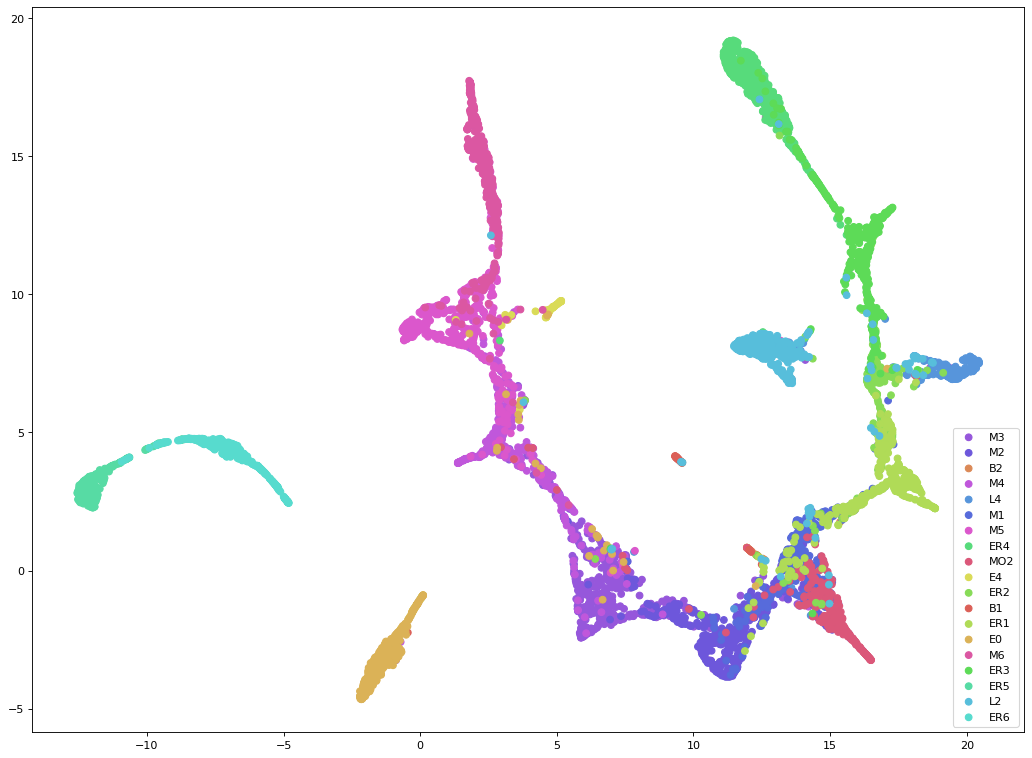

In [121]:
labels = [x.split('/')[-2] for x in X_test]
cellnames_test = {'cellname': labels, 'high_level': labels}
cellnames_test = pd.DataFrame(data=cellnames_test)
cellnames_test['dir'] = X_test
cellnames_test.head()

from matplotlib.pyplot import figure
import  matplotlib.pyplot as plt
#fig, ax = plt.subplots()
import seaborn as sns

figure(figsize=(16, 12), dpi=80)

x = projections[:, 0]
y = projections[:, 1]

classes = cellnames_test['high_level'].tolist()
colours = [sns.color_palette("hls", 19)[x] for x in cellnames_test['high_level'].map({"B1":0, "B2":1, "E0":2,
                                                             "E4":3, "ER1":4, "ER2":5,
                                                             "ER3":6, "ER4":7, "ER5":8,
                                                             "ER6":9, "L2":10, "L4":11,
                                                                 "M1":12,
                                                             "M2":13, "M3":14, "M4":15,
                                                             "M5":16, "M6":17, "MO2":18 })]


for (i,cla) in enumerate(set(classes)):
    xc = [p for (j,p) in enumerate(x) if classes[j]==cla]
    yc = [p for (j,p) in enumerate(y) if classes[j]==cla]
    cols = [c for (j,c) in enumerate(colours) if classes[j]==cla]
    plt.scatter(xc,yc,c=cols,label=cla)
plt.legend(loc=4)

In [96]:
#pred_class_binary = np.where(res,np.max(res, axis =1))

for i in range(res.shape[0]):
  if i == 0:
    index = np.where(res[i] == np.max(res[i]),1,0).reshape(1,19)
    
  else:
    _index = np.where(res[i] == np.max(res[i]),1,0).reshape(1,19)
    index = np.concatenate((index, _index), axis =0)
print(index.shape)

(6862, 19)


In [97]:
from sklearn.metrics import (roc_auc_score, accuracy_score, recall_score, precision_score, f1_score)
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

  #creating a set of all the unique classes using the actual class list
  class_num = res.shape[1]
  eval_dict = {}
  for per_class in range(class_num):
    #creating a list of all the classes except the current class 
    _class = actual_class[:,per_class]
    _pred  = pred_class[:,per_class]
    _pred_binary = index[:,per_class]
    #marking the current class as 1 and all other classes as 0

    roc_auc = roc_auc_score(_class, _pred, average = average)
    macro_f1 = f1_score(_class, _pred_binary)
    acc = accuracy_score(_class, _pred_binary)
    precision = precision_score(_class, _pred_binary)
    recall = recall_score(_class, _pred_binary)
    
    eval_dict[per_class] = [roc_auc, macro_f1, acc, precision, recall]

  return eval_dict

print("\nLogistic Regression")
# assuming your already have a list of actual_class and predicted_class from the logistic regression classifier
lr_roc_auc_multiclass = roc_auc_score_multiclass(celltypes, res)
print(lr_roc_auc_multiclass)


Logistic Regression
{0: [0.9986628962435414, 0.8409090909090908, 0.9979597784902361, 0.8043478260869565, 0.8809523809523809], 1: [0.9935737719703718, 0.6486486486486486, 0.9962110171961527, 0.6857142857142857, 0.6153846153846154], 2: [0.9938163758967477, 0.9046321525885558, 0.9897988924511805, 0.9171270718232044, 0.8924731182795699], 3: [0.995458285617339, 0.729281767955801, 0.9928592247158263, 0.7021276595744681, 0.7586206896551724], 4: [0.9864075417929984, 0.7460087082728593, 0.9744972311279511, 0.8107255520504731, 0.6908602150537635], 5: [0.9772902735950182, 0.6887417218543045, 0.9726027397260274, 0.6540880503144654, 0.7272727272727273], 6: [0.9937073259558555, 0.8250904704463208, 0.9788691343631595, 0.8658227848101265, 0.7880184331797235], 7: [0.9985355896565664, 0.9376693766937669, 0.9899446225590207, 0.9402173913043478, 0.9351351351351351], 8: [0.9990590824521216, 0.9490333919156415, 0.9957738268726319, 0.9782608695652174, 0.9215017064846417], 9: [0.9996785185528885, 0.956259426

In [104]:
df = pd.DataFrame(data=lr_roc_auc_multiclass)

df = df.T
df.columns = ['roc_auc', 'f1', 'acc', 'precision','recall']
df.index = [str(cell_types_df[cell_types_df['Cell_Types_Cat'] == x]['Cell_Types']).split('\n')[0].split(' ')[-1] for x in range(19)]
#dfto_csv('/')
df

,roc_auc,f1,acc,precision,recall
B1,0.998663,0.840909,0.997960,0.804348,0.880952
B2,0.993574,0.648649,0.996211,0.685714,0.615385
E0,0.993816,0.904632,0.989799,0.917127,0.892473
E4,0.995458,0.729282,0.992859,0.702128,0.758621
ER1,0.986408,0.746009,0.974497,0.810726,0.690860
ER2,0.977290,0.688742,0.972603,0.654088,0.727273
ER3,0.993707,0.825090,0.978869,0.865823,0.788018
ER4,0.998536,0.937669,0.989945,0.940217,0.935135
ER5,0.999059,0.949033,0.995774,0.978261,0.921502
ER6,0.999679,0.956259,0.995774,0.932353,0.981424


In [18]:
df.to_csv('../Result/ResNeXt50_pretrained/C_V/ResNeXt50_results_Interation3.tsv', sep='\t')